# Modelling

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import sparse

from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

from scipy.spatial import distance

from sklearn.manifold import TSNE

#from gensim.models.keyedvectors import WordEmbeddingsKeyedVectors

from gensim.models import KeyedVectors
import textwrap

from resources import *

#Import Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%run resources.py

In [ ]:
# Load user items data
recdata = pd.read_csv('recdata.csv', index_col=0)
recdata = recdata.rename(columns = {'variable':'id', 'value': 'owned'})
recdata.head()

In [ ]:
# Load games data
gamesdata = pd.read_csv('gamesdata.csv', index_col = 0)
gamesdata.head()

## Additional Preprocessing

In [ ]:
# Load the data
recdata = pd.read_csv('recdata.csv')

# Create a pivot table to create the interaction matrix
interactions = recdata.pivot_table(values='owned', index='uid', columns='id', fill_value=0)

# Print the shape of the matrix
print(interactions.shape)

#The pivot_table function creates a matrix with user IDs as rows, item IDs as columns, and the ratings as values. The fill_value parameter is used to fill the missing values with zero. This method is concise and can be easier to read and understand than the original method.

(4391, 7782)

From the shape, we note that we have 69277 unique users and 8791 different games represented.

In [ ]:
# Preview head
interactions.head()

id,10,20,30,40,50,60,70,80,130,220,...,523790,524340,525190,526460,526790,527340,527440,527510,527520,527810
uid,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train test split

In [ ]:
# Get number of users
len(interactions)

4391

In [ ]:
# Establish number of users in train/test sets
total_users = len(interactions)

train_num = int(total_users * 0.8)
test_num = total_users - train_num

print(f'We desire {train_num} users in our training set.')
print(f'We desire {test_num} users in our test set.')

# This script calculates the number of users to include in the training set and test set by taking 80% of the total number of users as the size of the training set, and the remaining 20% as the size of the test set. It then converts the result to integer using the int() function. Finally, it prints the desired number of users in each set.


We desire 3513.0 users in our training set.
We desire 878.0 users in our test set.


In [ ]:
# Define train and test sets
train = interactions[:3513]
test = interactions[3513:]

In [ ]:
# Create user dictionary using helper function
user_dict = create_user_dict(interactions=interactions)

In [ ]:
# Create game dictionary using helper function
games_dict = create_item_dict(df = gamesdata, id_col = 'id', name_col = 'title')

### Create sparse matrices

In [ ]:
# Create sparse matrices for evaluation 
train_sparse = sparse.csr_matrix(train.values)

#Add X users to Test so that the number of rows in Train match Test
N = train.shape[0] #Rows in Train set
n,m = test.shape #Rows & columns in Test set
z = np.zeros([(N-n),m]) #Create the necessary rows of zeros with m columns
#test = test.toarray() #Temporarily convert Test into a numpy array
test = np.vstack((test,z)) #Vertically stack Test on top of the blank users
test_sparse = sparse.csr_matrix(test) #Convert back to sparse

## Modelling using LightFM

### WARP loss model

In [ ]:
# Instantiate and fit model
mf_model_warp = run_model(interactions = train,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [ ]:
# Get precision
train_precision = precision_at_k(mf_model_warp, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.72, test 0.46.


In [ ]:
# Get AUC
train_auc = auc_score(mf_model_warp, train_sparse).mean()
test_auc = auc_score(mf_model_warp, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.98, test 0.92.


### BPR loss model

In [ ]:
# Instantiate and fit model
mf_model_bpr = run_model(interactions = train,
                 n_components = 30,
                 loss = 'bpr',
                 epoch = 30,
                 n_jobs = 4)

In [ ]:
# Get precision
train_precision = precision_at_k(mf_model_bpr, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_bpr, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.78, test 0.38.


In [ ]:
# Get AUC
train_auc = auc_score(mf_model_bpr, train_sparse).mean()
test_auc = auc_score(mf_model_bpr, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.96, test 0.72.


### Adjust number of components

In [ ]:
from lightfm import LightFM

mf_model_warp_2 = LightFM(no_components=10,
                          loss='warp',
                          learning_rate=0.05,
                          max_sampled=10,
                          random_state=42)
mf_model_warp_2.fit(train_sparse, epochs=30, num_threads=4)

# This script instantiates a LightFM model object with the warp 
# loss function and 10 components. 
# It then fits the model on the training set sparse 
# matrix train_sparse using the fit() method. 
# The epochs parameter is set to 30 and num_threads is set to 4 for parallel processing.
#  The max_sampled parameter is set to 10 to limit the number of negative samples used in each training iteration.

In [ ]:
# Get precision
train_precision = precision_at_k(mf_model_warp_2, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp_2, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.72, test 0.47.


In [ ]:
# Get AUC
train_auc = auc_score(mf_model_warp_2, train_sparse).mean()
test_auc = auc_score(mf_model_warp_2, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.98, test 0.92.


In [ ]:
# Instantiate and fit model
mf_model_warp_50 = run_model(interactions = train,
                 n_components = 50,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [ ]:
# Get precision
train_precision = precision_at_k(mf_model_warp_50, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp_50, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.75, test 0.45.


In [ ]:
# Get AUC
train_auc = auc_score(mf_model_warp_50, train_sparse).mean()
test_auc = auc_score(mf_model_warp_50, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.99, test 0.91.


### Final model

In [ ]:
# Create a matrix of user-item interactions
interaction_matrix = create_interaction_matrix(df=recdata,
                                               user_col='uid',
                                               item_col='id',
                                               rating_col='owned')

# Instantiate and fit a Matrix Factorization model on the interaction matrix
model = run_model(interactions=interaction_matrix,
                  n_components=30,
                  loss='warp',
                  epoch=30,
                  n_jobs=4)

# This code creates a matrix of user-item interactions using the create_interaction_matrix() function and passes it to the run_model() function to instantiate and fit a Matrix Factorization model with 30 components, 'warp' loss function, 30 epochs, and 4 parallel jobs. The resulting model object can be used to generate recommendations for new items that users may be interested in.


## Embeddings

In [ ]:
# Get embeddings
embeddings = mf_model.item_embeddings
embeddings

array([[-0.26347524, -0.49041584, -0.11776794, ..., -0.74186057,
         0.4700284 ,  0.7714332 ],
       [ 0.25411394, -0.5921972 , -0.2680336 , ..., -0.8885763 ,
         0.41085973,  1.2051992 ],
       [ 0.15867265, -0.46048754, -0.33062539, ..., -0.32519713,
         0.39393336,  0.9154534 ],
       ...,
       [-0.29790106,  0.30784997, -0.39334795, ...,  0.2936037 ,
        -0.4170378 , -0.29943746],
       [-0.27893615,  0.3405486 , -0.40960926, ...,  0.34614897,
        -0.41306883, -0.29618546],
       [-0.2707749 , -0.10337374, -0.28006732, ...,  0.017174  ,
        -0.21525294, -0.02542631]], dtype=float32)

In [ ]:
# View shape
embeddings.shape

(7782, 30)

In [ ]:
embeddings[0]

array([-0.26347524, -0.49041584, -0.11776794,  0.03829933, -0.6181473 ,
        0.12255388, -0.61208695, -0.16852547, -0.70402557,  0.06281453,
        0.32085815,  0.6037715 , -0.02053976, -0.46421272,  0.22947419,
       -0.31791502, -0.03766742,  0.43503067, -1.1750327 ,  0.28178984,
       -0.05132556,  0.18886529, -0.26266634,  0.47859162,  0.14941046,
        0.5364444 ,  0.4276168 , -0.74186057,  0.4700284 ,  0.7714332 ],
      dtype=float32)

In [ ]:
firstgameid = interactions.columns[0]
games_dict[firstgameid]

'Counter-Strike'

### Pair similarity

In [ ]:
# Get data for both games
gamesdata[(gamesdata['title']=='Counter-Strike') | (gamesdata['title']=='Left 4 Dead 2') ]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31529,Valve,['Action'],Left 4 Dead 2,Left 4 Dead 2,http://store.steampowered.com/app/550/Left_4_D...,2009-11-16,"['Zombies', 'Co-op', 'FPS', 'Multiplayer', 'Ac...",NaN,http://steamcommunity.com/app/550/reviews/?bro...,"['Single-player', 'Multi-player', 'Co-op', 'St...",19.99,False,550.0,Valve,Overwhelmingly Positive,89.0
32106,Valve,['Action'],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"['Multi-player', 'Valve Anti-Cheat enabled']",9.99,False,10.0,Valve,Overwhelmingly Positive,88.0


Let us look at the vectors for these two games.

In [ ]:
# Set index for Counter-Strike
cs_index = 0

# Obtain embeddings vector 
cs_vector = embeddings[cs_index]

cs_vector

array([-0.26347524, -0.49041584, -0.11776794,  0.03829933, -0.6181473 ,
        0.12255388, -0.61208695, -0.16852547, -0.70402557,  0.06281453,
        0.32085815,  0.6037715 , -0.02053976, -0.46421272,  0.22947419,
       -0.31791502, -0.03766742,  0.43503067, -1.1750327 ,  0.28178984,
       -0.05132556,  0.18886529, -0.26266634,  0.47859162,  0.14941046,
        0.5364444 ,  0.4276168 , -0.74186057,  0.4700284 ,  0.7714332 ],
      dtype=float32)

In [ ]:
# Retrieve game id for LFD2
lfd2_id = gamesdata[gamesdata['title']=='Left 4 Dead 2']['id'].values[0]

# Obtain index for Squad in interactions matrix
lfd2_index = list(interactions.columns).index(lfd2_id)

# Obtain embeddings vector
lfd2_vector = embeddings[lfd2_index]

lfd2_vector

array([ 0.5521016 , -0.51231575,  0.6150829 ,  0.05742715, -0.3029531 ,
       -0.57554674, -0.6507477 , -0.30448958, -0.5614537 , -0.13323176,
        0.39140487,  0.3397645 ,  0.33942077, -0.6524269 ,  0.5002701 ,
        0.338048  , -0.27147165, -0.33555028, -0.752357  ,  0.13197729,
        0.3464362 , -0.72857225, -0.42311838,  0.0697218 ,  0.0545343 ,
        0.3421308 , -0.42475092, -0.46501607,  0.8809167 ,  0.7060979 ],
      dtype=float32)

In [ ]:
# Compute Euclidean distance
distance.euclidean(cs_vector, lfd2_vector)

2.3826918601989746

In [ ]:
# Get data for both games
gamesdata[(gamesdata['title']=='Counter-Strike') | (gamesdata['title']=='The Room') ]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
2472,Fireproof Games,"['Adventure', 'Indie']",The Room,The Room,http://store.steampowered.com/app/288160/The_R...,2014-07-28,"['Puzzle', 'Adventure', 'Point & Click', 'Indi...",NaN,http://steamcommunity.com/app/288160/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",4.99,False,288160.0,Fireproof Games,Overwhelmingly Positive,73.0
32106,Valve,['Action'],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"['Multi-player', 'Valve Anti-Cheat enabled']",9.99,False,10.0,Valve,Overwhelmingly Positive,88.0


In [ ]:
# Retrieve game id for The Room
room_id = gamesdata[gamesdata['title']=='The Room']['id'].values[0]

# Obtain index for Squad in interactions matrix
room_index = list(interactions.columns).index(room_id)

# Obtain embeddings vector
room_vector = embeddings[room_index]

room_vector

array([-0.09446802, -0.03180934,  0.22380084,  0.01971596,  0.23833464,
       -0.5790806 ,  0.01657455,  0.25947765, -0.40233773, -0.02788007,
        0.06172375, -0.00574101, -0.11654654,  0.10654981,  0.07530343,
        0.48087186,  0.19813076, -0.2870761 , -0.11533125,  0.10813959,
        0.14742695,  0.18410027,  0.26294008,  0.21751276,  0.23955107,
        0.071257  , -0.05437781, -0.3299016 ,  0.15873829,  0.43641534],
      dtype=float32)

In [ ]:
# Compute Euclidean distance
distance.euclidean(cs_vector, room_vector)

2.577725410461426

In [ ]:
print(f'Cosine distance between Counter Strike and Left 4 Dead 2: {distance.cosine(cs_vector, lfd2_vector)}')
print(f'Cosine distance between Counter Strike and The Room: {distance.cosine(cs_vector, room_vector)}')

Cosine distance between Counter Strike and Left 4 Dead 2: 0.4330061078071594
Cosine distance between Counter Strike and The Room: 0.7957022190093994


### Exploring embeddings with Gensim

In [ ]:
# Set embedding size
embedding_size = embeddings.shape[1]

# Create instance
kv = KeyedVectors(vector_size=embedding_size)

# Get list of game names in correct order to match embeddings
gameslist = []
for game_id in interactions.columns:
    name = games_dict[game_id]
    gameslist.append(name)

# Add vectors to kv
kv.add_vectors(gameslist, embeddings)

In [ ]:
# Get games closest to Counter-Strike
kv.most_similar('Counter-Strike')

[('Counter-Strike: Condition Zero', 0.9898017048835754),
 ('Half-Life: Source', 0.8028128743171692),
 ('Half-Life: Opposing Force', 0.7977452278137207),
 ('Team Fortress Classic', 0.7839943170547485),
 ('Half-Life: Blue Shift', 0.7686489820480347),
 ('Day of Defeat', 0.7682018876075745),
 ('Day of Defeat: Source', 0.762607216835022),
 ('Counter-Strike: Source', 0.7558994293212891),
 ('Deathmatch Classic', 0.7526051998138428),
 ('Half-Life', 0.7519853711128235)]

In [ ]:
# Get games closest to Left 4 Dead 2
kv.most_similar('Left 4 Dead 2')

[('Counter-Strike: Global Offensive', 0.916785717010498),
 ("Garry's Mod", 0.9084900617599487),
 ('PAYDAY™ The Heist', 0.907978892326355),
 ('Counter-Strike: Source', 0.9017037153244019),
 ('Borderlands 2', 0.8990370631217957),
 ('Chivalry: Medieval Warfare', 0.8842626214027405),
 ('Saints Row: The Third', 0.8735359907150269),
 ("Mirror's Edge™", 0.8711438775062561),
 ('Portal 2', 0.8606310486793518),
 ('Just Cause 2', 0.8596335053443909)]

In [ ]:
# Get games closest to The Room
kv.most_similar('The Room')

[('Mass Effect', 0.6038333773612976),
 ('Dishonored', 0.5912261009216309),
 ('System Shock 2', 0.5698769092559814),
 ('Bastion', 0.5664722323417664),
 ('Cargo Commander', 0.56336510181427),
 ('Portal 2', 0.5582819581031799),
 ('Puddle', 0.5569257140159607),
 ("Baldur's Gate: Enhanced Edition", 0.5486471056938171),
 ('Magic 2014 — Duels of the Planeswalkers', 0.5478231310844421),
 ('The Binding of Isaac: Rebirth', 0.5403820276260376)]

In [ ]:
# Get games closest to RollerCoaster Tycoon
kv.most_similar('RollerCoaster Tycoon®: Deluxe')

[('RollerCoaster Tycoon® 2: Triple Thrill Pack', 0.8383820652961731),
 ('RPG Maker MV', 0.5635203719139099),
 ("Who's Your Daddy", 0.5571008920669556),
 ('The Ship: Remasted', 0.5302398204803467),
 ('The Sims™ 3', 0.5266623497009277),
 ('Domestic Dog', 0.5172269344329834),
 ('LEGO® Worlds', 0.5132834911346436),
 ('Deponia: The Complete Journey', 0.5020038485527039),
 ('Angry Video Game Nerd II: ASSimilation', 0.5000352263450623),
 ('RollerCoaster Tycoon® 3: Platinum', 0.49966439604759216)]

In [ ]:
# Get games closest to Dishonored
kv.most_similar('Dishonored')

[('BioShock Infinite', 0.8936492204666138),
 ('Fallout: New Vegas', 0.8676444888114929),
 ('The Witcher 2: Assassins of Kings Enhanced Edition', 0.8585086464881897),
 ('Far Cry 3 - Blood Dragon', 0.8343015909194946),
 ('Fallout 4', 0.8342387080192566),
 ('BioShock™ 2 Remastered', 0.8332837224006653),
 ('BioShock™ Remastered', 0.8307978510856628),
 ('Fallout 3: Game of the Year Edition', 0.8285755515098572),
 ('Far Cry 3', 0.8254615068435669),
 ('BioShock™', 0.8241872787475586)]

In [ ]:
# Get games closest to The Jackbox Party Pack
kv.most_similar('The Jackbox Party Pack')

[('Stardew Valley', 0.7257013320922852),
 ('Party Hard', 0.694216251373291),
 ('Undertale', 0.6662869453430176),
 ('South Park™: The Stick of Truth™', 0.6586517691612244),
 ('Plague Inc: Evolved', 0.6500663757324219),
 ('Quantum Conundrum', 0.6400678753852844),
 ('Gang Beasts', 0.618651270866394),
 ('Dead State: Reanimated', 0.6162086725234985),
 ('Town of Salem', 0.6093379855155945),
 ('What The Box?', 0.5974676012992859)]

In [ ]:
# Get games closest to American Truck Simulator
kv.most_similar('American Truck Simulator')

[('BeamNG.drive', 0.7652981281280518),
 ('Jalopy', 0.7460778951644897),
 ('Microsoft Flight Simulator X: Steam Edition', 0.7314549684524536),
 ('Farming Simulator 15', 0.7279736399650574),
 ('Medieval Engineers', 0.7052158713340759),
 ('Next Car Game: Wreckfest', 0.6905338168144226),
 ('Rising World', 0.6887257695198059),
 ('The Isle', 0.680105447769165),
 ('Stranded Deep', 0.6755014657974243),
 ('The Crew™', 0.6736965179443359)]

In [ ]:
def plot_similar(item, ax, topn=5):
    '''
    Plots a bar chart of similar items
    Arguments:
        - item, string
        - ax, axes on which to plot
        - topn (default = 5) number of similar items to plot
    '''
    similar_items = kv.similar_by_word(item, topn=topn, restrict_vocab=None)
    y = np.arange(len(similar_items))
    w = [t[1] for t in similar_items]
    ax.barh(y, w)
    left = min(.6, min(w))
    ax.set_xlim(right=1.0, left=left)
    # Split long titles over multiple lines
    labels = [textwrap.fill(t[0] , width=24)
              for t in similar_items]
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_title(item)

    # It calculates the most similar items to the given item and plots a bar chart of their similarity scores, with labels for each item. The topn argument determines how many similar items to plot.


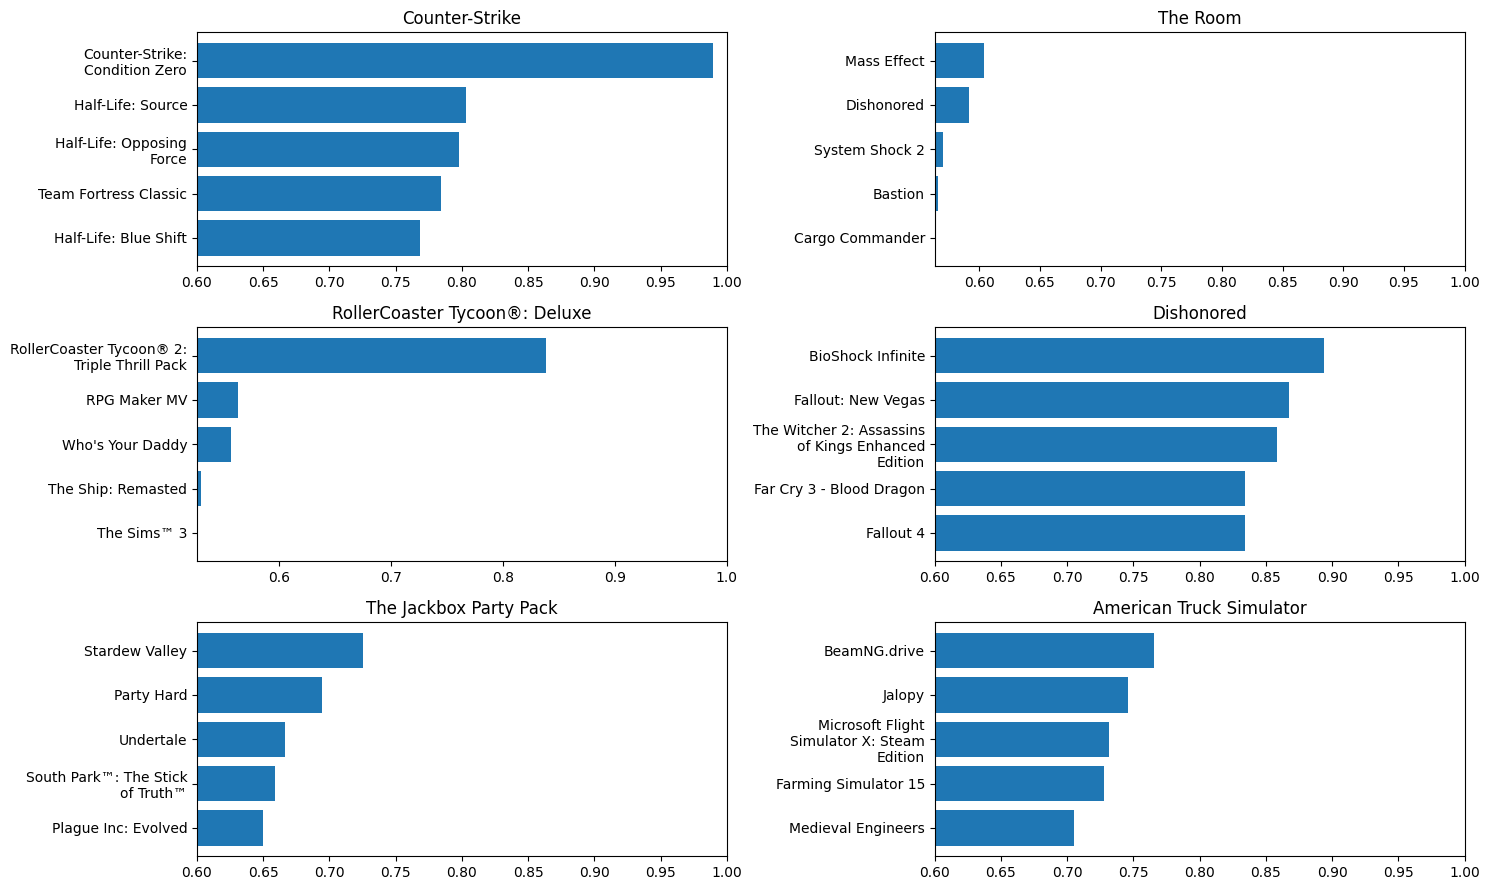

In [ ]:
# Define list of games to visualise similar items for
games = ['Counter-Strike', 'The Room', 'RollerCoaster Tycoon®: Deluxe', 'Dishonored', 
         'The Jackbox Party Pack', 'American Truck Simulator']

# Set figure/axes to have 3 rows with 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 9))

# Loop through games and use plot_similar function 
for game, ax in zip(games, axes.flatten()):
    plot_similar(game, ax)
    
fig.tight_layout()

### Visualizing embeddings with t-SNE

In [ ]:
# Instantialte tsne, specify cosine metric
tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')

# Fit and transform
embeddings2d = tsne.fit_transform(embeddings)

In [ ]:
# Create DF
embeddingsdf = pd.DataFrame()

# Add game names
embeddingsdf['game'] = gameslist

# Add x coordinate
embeddingsdf['x'] = embeddings2d[:,0]

# Add y coordinate
embeddingsdf['y'] = embeddings2d[:,1]

# Check
embeddingsdf.head()

,game,x,y
0,Counter-Strike,67.204956,-14.035009
1,Team Fortress Classic,66.645279,-13.415462
2,Day of Defeat,67.179680,-13.436792
3,Deathmatch Classic,67.185249,-13.387955
4,Half-Life: Opposing Force,66.435432,-13.462366


Let's draw a scatterplot of our games, using the 2D mapping we created.

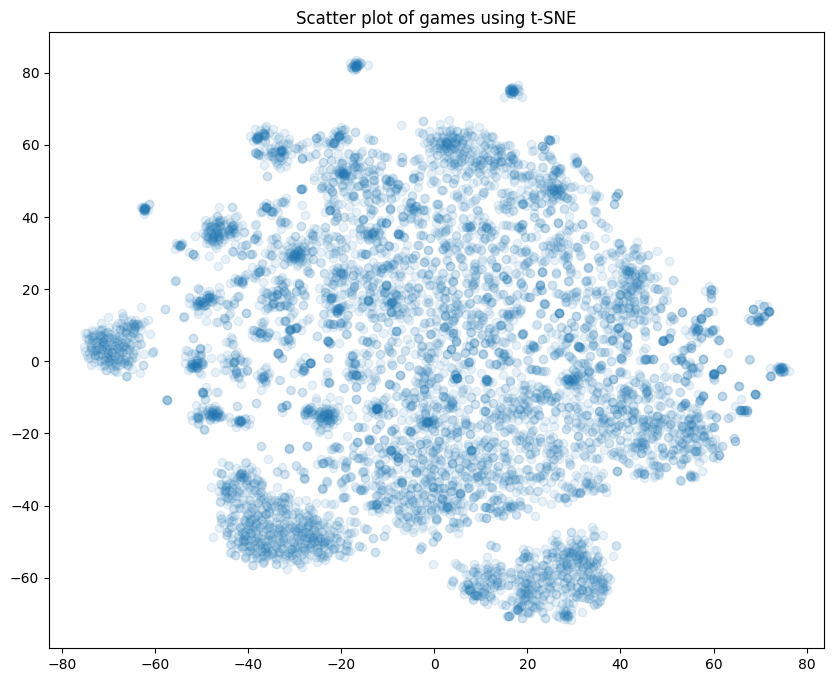

In [ ]:
# Set figsize
fig, ax = plt.subplots(figsize=(10,8))

# Scatter points, set alpha low to make points translucent
ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.1)

plt.title('Scatter plot of games using t-SNE')

plt.show()

In [ ]:
match = embeddingsdf[embeddingsdf.game.str.contains('RollerCoaster')]
match

,game,x,y
70,RollerCoaster Tycoon® 3: Platinum,36.243572,-15.987335
2811,RollerCoaster Tycoon World™,0.765737,-16.871269
2889,RollerCoaster Tycoon®: Deluxe,33.227894,-22.280470
2890,RollerCoaster Tycoon® 2: Triple Thrill Pack,33.192730,-22.293716


We will highlight the above games on our scatter plot.

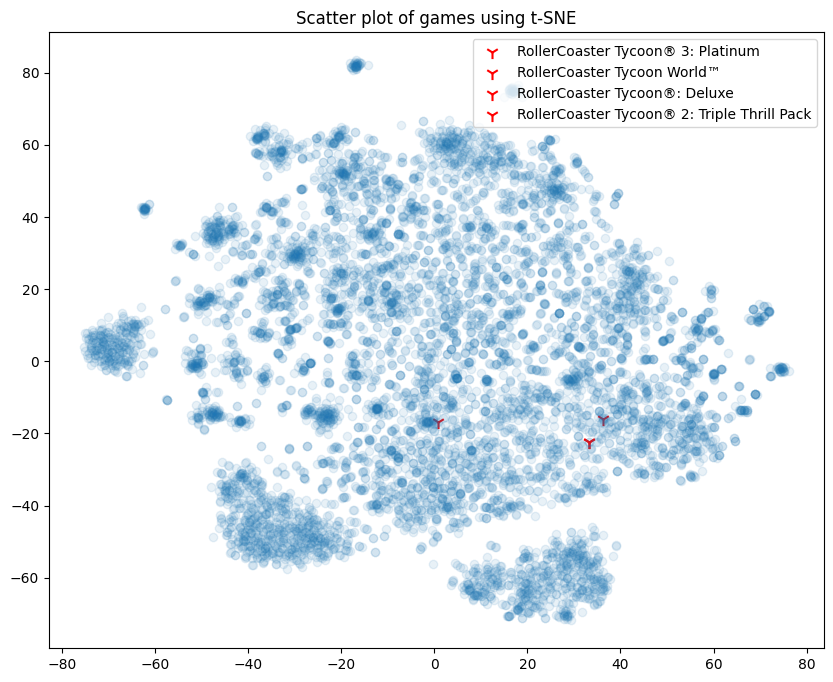

In [ ]:
# Set figsize
fig, ax = plt.subplots(figsize=(10,8))

Xlabeled = embeddings2d[match.index, 0]
Ylabeled = embeddings2d[match.index, 1]
labels = match['game'].values

# Scatter specific points
for x, y, label in zip(Xlabeled, Ylabeled, labels):
    ax.scatter(x, y, marker='1', label = label, s=90, color = 'red')

# Scatter points, set alpha low to make points translucent
ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.1)

plt.title('Scatter plot of games using t-SNE')
plt.legend()

plt.show()

## User Recommendations

### Recommendations for existing user

In [ ]:
# Get recommendations
rec_list_u12 = get_recs(model = mf_model, 
                    interactions = interactions, 
                    user_id = 413, 
                    user_dict = user_dict,
                    item_dict = games_dict, 
                    threshold = 0,
                    num_items = 5,
                    show_known = True, 
                    show_recs = True)

Known Likes:
1- Youtubers Life
2- Clicker Heroes
3- TERA
4- Robocraft
5- Always Sometimes Monsters
6- Counter-Strike Nexon: Zombies
7- Breach &amp; Clear
8- Fistful of Frags
9- Tesla Effect: A Tex Murphy Adventure
10- KickBeat Steam Edition
11- METAL SLUG 3
12- Blackguards
13- Draw a Stickman: EPIC
14- Elsword
15- Warframe
16- Skulls of the Shogun
17- Euro Truck Simulator 2
18- Sacred 2 Gold
19- No More Room in Hell
20- Insurgency
21- Fieldrunners 2
22- Half Minute Hero: Super Mega Neo Climax Ultimate Boy
23- Loadout
24- Symphony
25- Saints Row IV
26- Really Big Sky
27- Galcon Legends
28- Dino D-Day
29- Saints Row: The Third
30- Fortix
31- GRID 2
32- Galcon Fusion
33- Risen 2: Dark Waters
34- Mirror's Edge™
35- Saints Row 2
36- Garry's Mod
37- Portal 2

 Recommended Items:
1- Unturned
2- Counter-Strike: Global Offensive
3- Terraria
4- Left 4 Dead 2
5- Awesomenauts - the 2D moba


## Item Recommendations

In [ ]:
item_dist = create_item_emdedding_matrix(model = mf_model,interactions = interactions)

In [ ]:
item_dist.shape

(7782, 7782)

In [ ]:
item_dist.head()

id,10,20,30,40,50,60,70,80,130,220,...,523790,524340,525190,526460,526790,527340,527440,527510,527520,527810
id,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.783994,0.768202,0.752605,0.797745,0.741419,0.751985,0.989802,0.768649,0.667653,...,-0.377031,-0.492871,-0.479669,-0.504541,-0.367029,-0.085988,-0.500864,-0.468600,-0.454809,-0.044617
20,0.783994,1.000000,0.851148,0.862030,0.980612,0.869749,0.968076,0.751852,0.993701,0.810599,...,-0.325828,-0.465349,-0.473539,-0.504446,-0.323179,-0.053690,-0.329346,-0.469251,-0.465362,-0.086226
30,0.768202,0.851148,1.000000,0.989791,0.831696,0.983136,0.794195,0.696493,0.859450,0.584723,...,-0.232149,-0.329816,-0.321546,-0.308136,-0.158740,-0.150683,-0.241987,-0.291731,-0.284601,-0.079215
40,0.752605,0.862030,0.989791,1.000000,0.832515,0.992162,0.801715,0.682782,0.865910,0.589461,...,-0.234649,-0.340335,-0.331320,-0.319818,-0.169985,-0.161108,-0.226015,-0.306835,-0.282990,-0.080512
50,0.797745,0.980612,0.831696,0.832515,1.000000,0.843888,0.978432,0.766986,0.986093,0.880117,...,-0.414476,-0.557313,-0.572833,-0.607926,-0.442838,-0.065148,-0.406256,-0.572153,-0.584988,-0.129065


In [ ]:
# Similar items to item_id 10 - Counter Strike
item_rec_list_10 = get_item_recs(item_emdedding_matrix = item_dist, 
                              item_id = 10, 
                              item_dict = games_dict, 
                              n_items = 5, 
                              show = True)

Item of interest: Counter-Strike
Similar items:
1- Counter-Strike: Condition Zero
2- Half-Life: Source
3- Half-Life: Opposing Force
4- Team Fortress Classic
5- Half-Life: Blue Shift


In [ ]:
gamesdata[gamesdata['title'] == 'The Witness']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
5211,"Thekla, Inc.","['Adventure', 'Indie']",The Witness,The Witness,http://store.steampowered.com/app/210970/The_W...,2016-01-26,"['Puzzle', 'Exploration', 'First-Person', 'Sin...",NaN,http://steamcommunity.com/app/210970/reviews/?...,"['Single-player', 'Steam Achievements', 'Capti...",39.99,False,210970.0,"Thekla, Inc.",Very Positive,87.0


In [ ]:
# Similar items to item_id 210970 The Witness
item_rec_list_210970 = get_item_recs(item_emdedding_matrix = item_dist, 
                              item_id = 210970, 
                              item_dict = games_dict, 
                              n_items = 5, 
                              show = True)

Item of interest: The Witness
Similar items:
1- ABZU
2- Hyper Light Drifter
3- Axiom Verge
4- Ori and the Blind Forest: Definitive Edition
5- Stories: The Path of Destinies


In [ ]:
gamesdata[gamesdata['title'] == 'American Truck Simulator']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
24195,SCS Software,"['Indie', 'Simulation']",American Truck Simulator,American Truck Simulator,http://store.steampowered.com/app/270880/Ameri...,2016-02-02,"['Simulation', 'Driving', 'Open World', 'Ameri...",NaN,http://steamcommunity.com/app/270880/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",19.99,False,270880.0,SCS Software,Very Positive,76.0


In [ ]:
gamesdata[gamesdata['title'] == "The Elder Scrolls V: Skyrim Special Edition"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
7766,Bethesda Softworks,['RPG'],The Elder Scrolls V: Skyrim Special Edition,The Elder Scrolls V: Skyrim Special Edition,http://store.steampowered.com/app/489830/The_E...,2016-10-27,"['Open World', 'RPG', 'Adventure', 'Fantasy', ...",NaN,http://steamcommunity.com/app/489830/reviews/?...,"['Single-player', 'Steam Achievements', 'Parti...",39.99,False,489830.0,Bethesda Game Studios,Mostly Positive,74.0


In [ ]:
item_rec_list_12140 = get_item_recs(item_emdedding_matrix = item_dist, 
                              item_id = 12140, 
                              item_dict = games_dict, 
                              n_items = 5, 
                              show = True)

Item of interest: Max Payne
Similar items:
1- Max Payne 2: The Fall of Max Payne
2- Hitman: Blood Money
3- Deus Ex: Revision
4- L.A. Noire
5- Bully: Scholarship Edition


In [ ]:
gamesdata.iloc[100:110]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
100,SEGA,['Strategy'],Rome: Total War™ - Alexander,Rome: Total War™ - Alexander,http://store.steampowered.com/app/4770/Rome_To...,2006-06-26,"['Strategy', 'RTS', 'Historical', 'Grand Strat...",NaN,http://steamcommunity.com/app/4770/reviews/?br...,"['Single-player', 'Multi-player']",4.99,False,4770.0,The Creative Assembly,Mostly Positive,79.0
101,Big Fish Games,['Casual'],Mystery Case Files: Madame Fate®,Mystery Case Files: Madame Fate®,http://store.steampowered.com/app/50970/Myster...,2007-12-14,"['Casual', 'Hidden Object']",NaN,http://steamcommunity.com/app/50970/reviews/?b...,['Single-player'],6.99,False,50970.0,Big Fish Games,Mostly Positive,NaN
102,Rockstar Games,['Action'],Grand Theft Auto,Grand Theft Auto,http://store.steampowered.com/app/12170/Grand_...,1998-06-30,"['Action', 'Classic', 'Open World', 'Singlepla...",NaN,http://steamcommunity.com/app/12170/reviews/?b...,['Single-player'],NaN,False,12170.0,Rockstar North,Very Positive,NaN
103,Rockstar Games,['Action'],Grand Theft Auto 2,Grand Theft Auto 2,http://store.steampowered.com/app/12180/Grand_...,1999-10-25,"['Action', 'Classic', 'Open World', 'Singlepla...",NaN,http://steamcommunity.com/app/12180/reviews/?b...,['Single-player'],NaN,False,12180.0,Rockstar North,Very Positive,NaN
104,Rockstar Games,['Action'],Manhunt,Manhunt,http://store.steampowered.com/app/12130/Manhunt/,2004-04-20,"['Gore', 'Stealth', 'Action', 'Horror', 'Viole...",NaN,http://steamcommunity.com/app/12130/reviews/?b...,['Single-player'],9.99,False,12130.0,Rockstar North,Mixed,75.0
105,Rockstar Games,['Racing'],Midnight Club 2,Midnight Club 2,http://store.steampowered.com/app/12160/Midnig...,2003-07-01,"['Racing', 'Open World', 'Great Soundtrack', '...",NaN,http://steamcommunity.com/app/12160/reviews/?b...,"['Single-player', 'Multi-player']",9.99,False,12160.0,Rockstar San Diego,Very Positive,81.0
106,Rockstar Games,['Action'],Max Payne 2: The Fall of Max Payne,Max Payne 2: The Fall of Max Payne,http://store.steampowered.com/app/12150/Max_Pa...,2003-10-14,"['Noir', 'Action', 'Third-Person Shooter', 'Cl...",NaN,http://steamcommunity.com/app/12150/reviews/?b...,['Single-player'],9.99,False,12150.0,Remedy Entertainment,Very Positive,86.0
107,Square Enix,"['Action', 'Adventure']",Tomb Raider: Legend,Tomb Raider: Legend,http://store.steampowered.com/app/7000/,2006-04-07,"['Adventure', 'Action', 'Female Protagonist', ...",NaN,http://steamcommunity.com/app/7000/reviews/?br...,"['Single-player', 'Partial Controller Support']",6.99,False,7000.0,Crystal Dynamics,Very Positive,82.0
108,Rockstar Games,['Action'],Max Payne,Max Payne,http://store.steampowered.com/app/12140/Max_Pa...,2001-07-25,"['Noir', 'Action', 'Classic', 'Third-Person Sh...",NaN,http://steamcommunity.com/app/12140/reviews/?b...,['Single-player'],9.99,False,12140.0,Remedy Entertainment,Very Positive,89.0
109,Electronic Arts,['Strategy'],Command & Conquer: Red Alert 3,Command &amp; Conquer: Red Alert 3,http://store.steampowered.com/app/17480/Comman...,2008-10-28,"['Strategy', 'RTS', 'Base Building', 'Multipla...",NaN,http://steamcommunity.com/app/17480/reviews/?b...,['Single-player'],19.99,False,17480.0,EA Los Angeles,Very Positive,82.0


## Recommendations for new user - Demo

In [ ]:
interactions

id,10,20,30,40,50,60,70,80,130,220,...,523790,524340,525190,526460,526790,527340,527440,527510,527520,527810
uid,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Interface

In [ ]:
def final_system(user_dict, games_dict, mf_model, item_dist, interactions):
    user_id = int(float(input('Enter user id: ')))
    game_id = int(float(input('Enter game id: ')))
    # Get recommendations
    rec_list_u12 = get_recs(model = mf_model, 
                        interactions = interactions, 
                        user_id = user_id, 
                        user_dict = user_dict,
                        item_dict = games_dict, 
                        threshold = 0,
                        num_items = 5,
                        show_known = True, 
                        show_recs = True)
    
    # Similar items to item_id 10 - Counter Strike
    item_rec_list_10 = get_item_recs(item_emdedding_matrix = item_dist, 
                                  item_id = game_id, 
                                  item_dict = games_dict, 
                                  n_items = 5, 
                                  show = True)
    print('User recommendations on what you have playd: ', rec_list_u12)
    print('Item recommendations based on the ID you entered: ', item_rec_list_10)
    return rec_list_u12, item_rec_list_10

#final_system(user_dict, games_dict, mf_model, item_dist, interactions)

Example games owned:
* 210970 The Witness
* 288160 The Room
* 550 Left 4 Dead 2